In [81]:
import pathlib as plb

import dicom2nifti
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pydicom 

In [82]:
# specify dicom directory: 
dicom_dir = '/home/thepp/out'
dicom_dir = plb.Path(dicom_dir)

### Convert DICOM to NIFTI

In [83]:
nifti_dir = dicom_dir/'nifti'
nifti_dir.mkdir(exist_ok=True)

In [84]:
# sort pet and ct dicom files
dicom_files = {'CT': [], 'PT': []}
for f in dicom_dir.glob('*.dcm'):
    modality = pydicom.dcmread(str(f)).Modality
    assert modality in ['PT', 'CT']
    dicom_files[modality].append(str(f))
print(f'{len(dicom_files["PT"])} PET dicom files, {len(dicom_files["CT"])} CT dicom files')

285 PET dicom files, 342 CT dicom files


In [85]:
# convert dicom direcotry to nifti
dicom2nifti.convert_directory(dicom_dir, nifti_dir, compression=True, reorient=True)

### SUV intensity conversion

In [86]:
def conv_time(time_str):
    return (float(time_str[:2]) * 3600 + float(time_str[2:4]) * 60 + float(time_str[4:13]))

def calculate_suv_factor(dcm_path):
    ds = pydicom.dcmread(str(dcm_path))
    total_dose = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose
    start_time = ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime
    half_life = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife
    acq_time = ds.AcquisitionTime
    weight = ds.PatientWeight
    time_diff = conv_time(acq_time) - conv_time(start_time)
    act_dose = total_dose * 0.5 ** (time_diff / half_life)
    suv_factor = 1000 * weight / act_dose
    return suv_factor

In [87]:
def convert_pet(pet, suv_factor=1.0):
    affine = pet.affine
    pet_data = pet.get_fdata()
    pet_suv_data = (pet_data*suv_factor).astype(np.float32)
    pet_suv = nib.Nifti1Image(pet_suv_data, affine)
    return pet_suv 

In [88]:
sample_dcm_file = dicom_files['PT'][0]
suv_corr_factor = calculate_suv_factor(sample_dcm_file)
print(f'SUV correction factor: {suv_corr_factor}')

SUV correction factor: 0.00037154985878911175


In [89]:
raw_pet_nii = next(nifti_dir.glob('*pet*'))
suv_pet_nii = convert_pet(nib.load(raw_pet_nii), suv_factor=suv_corr_factor)
nib.save(suv_pet_nii, raw_pet_nii.parent/('suv_' + raw_pet_nii.name ))

### Check data

In [90]:
suv_data = suv_pet_nii.get_fdata()
print(f'SUV max {suv_data.max()} SUV min {suv_data.min()}')

SUV max 54.26996612548828 SUV min 0.0


In [91]:
print(suv_pet_nii.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 400 400 285   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.       2.03642  2.03642  3.       1.       1.       1.       1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 406.662
qoffset_y       : -154.03758
qoffset_z       : 

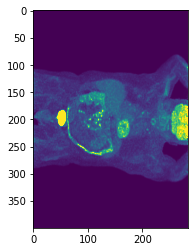

In [92]:
plt.imshow(suv_pet_nii.get_fdata().max(axis=1), vmin=0.0, vmax=10.0)